<a href="https://colab.research.google.com/github/GuilhermeFerracini/Machine_Learning/blob/main/Deep_Learning/MNIST_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libs
import torch
from torch import nn, optim

from torchvision import datasets #Conjunto de datasets ja em formato torch
from torchvision import transforms #Transformação

from torch.utils.data import DataLoader #Batchs e threads

import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Hiperparâmetros.
args = {
    'epoch_num': 100,     # Número de épocas.
    'batch_size': 2000,     # Tamanho do batch.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 2,     # Número de threads do dataloader.
    'num_classes': 10     # Numero de classes

}

# GPU or CPU
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


In [3]:
#Dataset
#data = datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
train_set = datasets.MNIST('./',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_set = datasets.MNIST('./',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

print('Amostras de treino: ' + str(len(train_set)) + '\nAmostras de Teste:' + str(len(test_set)))


100%|██████████| 9912422/9912422 [00:00<00:00, 122661031.32it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7946450.66it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75404683.94it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1453573.08it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Amostras de treino: 60000
Amostras de Teste:10000


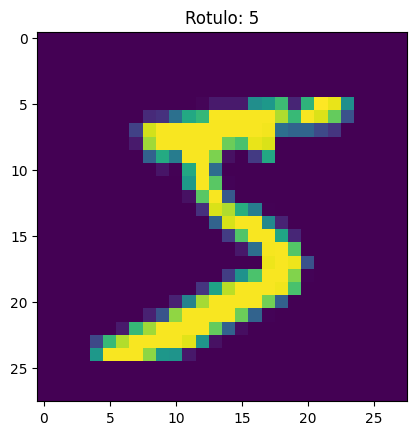

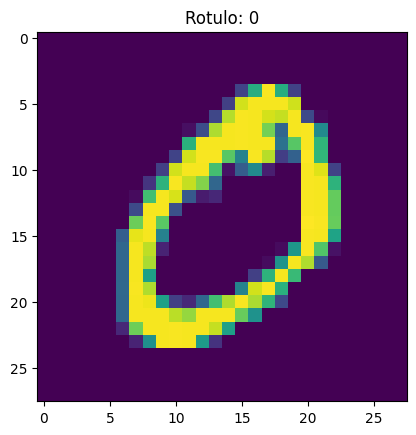

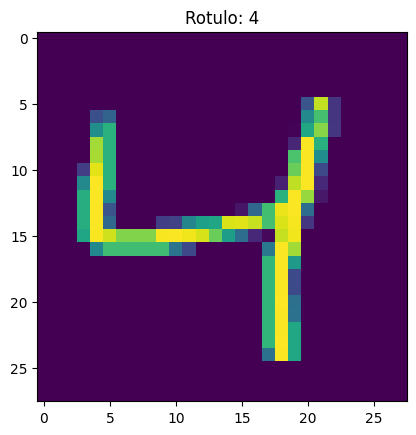

In [4]:
#Pre-Visualizando DataSet
for i in range(3):
  dado, rotulo = train_set[i]

  plt.figure()
  plt.imshow(dado[0])
  plt.title('Rotulo: '+ str(rotulo))

In [5]:
#DataLoader
#loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          shuffle=True,
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set,
                          batch_size=args['batch_size'],
                          shuffle=False,
                          num_workers=args['num_workers'])
#O objeto retornado é um iterador, podendo ser utilizado para iterar em loops mas não suportando indexação
for batch in test_loader:

  dado, rotulo = batch
  print('\n## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size()) #

  break


## Dimensionalidade do batch ##
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


In [6]:
#MLP
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features  = nn.Sequential(
                      nn.Linear(input_size, hidden_size),
                      nn.ReLU(),
                      nn.Linear(hidden_size, hidden_size),
                      nn.ReLU()
                    )
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()

  def forward(self, X):

    X = X.view(X.size(0), -1) #Reshaped em flattened image

    feature = self.features(X)
    output  = self.softmax(self.out(feature))

    return output

input_size  = 28 * 28 #Dimensionamento da img
hidden_size = 128
out_size    = 10 #Num_classes

torch.manual_seed(42)
net = MLP(input_size, hidden_size, out_size).to(args['device']) #cast na GPU

In [7]:
#Optmizer and Loss Function
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [9]:
# Fluxo de treinamento
# Iterar nas épocas
# Iterar nos batches
# Cast dos dados no dispositivo de hardware
# Forward na rede e cálculo da loss
# Cálculo do gradiente e atualização dos pesos

def train(train_loader, net, epoch):

  # Training mode
  net.train()

  start = time.time()

  epoch_loss  = []
  for batch in train_loader:

    dado, rotulo = batch

    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])

    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    # Backpropagation
    loss.backward()
    optimizer.step()

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [10]:
# Fluxo de teste
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()

  start = time.time()

  epoch_loss  = []

  with torch.no_grad():
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)

  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

  return epoch_loss.mean()

In [11]:
# Train e Test: Iterar nas epocas
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):

  # Train
  train_losses.append(train(train_loader, net, epoch))

  # Validate
  test_losses.append(validate(test_loader, net, epoch))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


#################### Train ####################
Epoch 0, Loss: 2.3002 +/- 0.0013, Time: 13.27
********** Validate **********
Epoch 0, Loss: 2.2974 +/- 0.0006, Time: 1.19

#################### Train ####################
Epoch 1, Loss: 2.2938 +/- 0.0025, Time: 8.03
********** Validate **********
Epoch 1, Loss: 2.2886 +/- 0.0016, Time: 1.23

#################### Train ####################
Epoch 2, Loss: 2.2814 +/- 0.0050, Time: 6.98
********** Validate **********
Epoch 2, Loss: 2.2711 +/- 0.0038, Time: 1.90

#################### Train ####################
Epoch 3, Loss: 2.2576 +/- 0.0093, Time: 8.07
********** Validate **********
Epoch 3, Loss: 2.2382 +/- 0.0084, Time: 1.56

#################### Train ####################
Epoch 4, Loss: 2.2157 +/- 0.0158, Time: 8.09
********** Validate **********
Epoch 4, Loss: 2.1872 +/- 0.0138, Time: 1.25

#################### Train ####################
Epoch 5, Loss: 2.1588 +/- 0.0177, Time: 8.11
********** Validate **********
Epoch 5, Loss: 2.1220 +/-

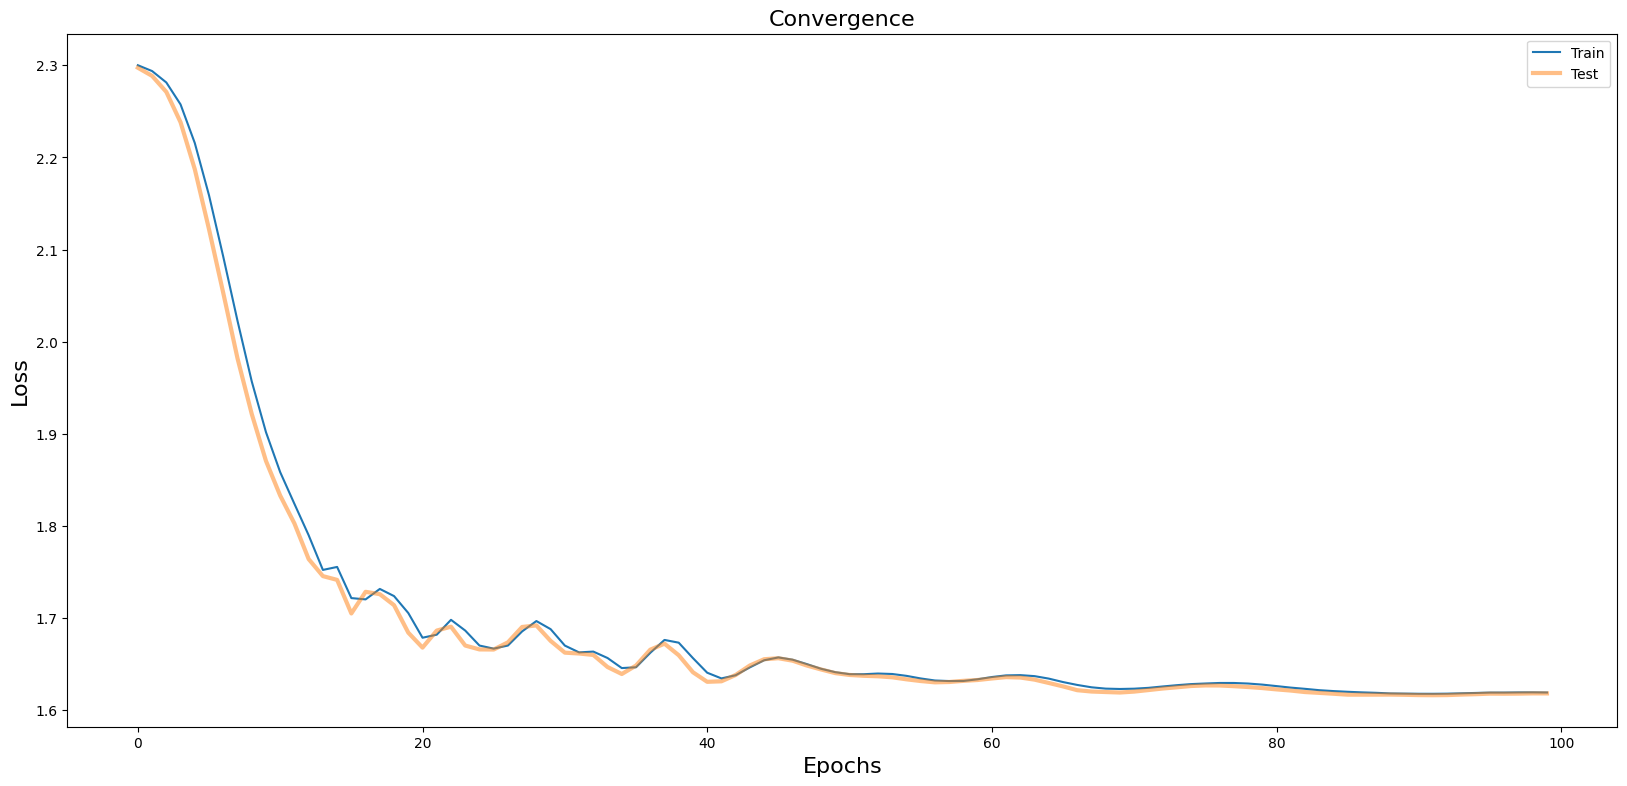

In [12]:
# Convergencia
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()